In [1]:
import scipy
import numpy
import math
from features import mfcc
from scipy.io import wavfile
from scipy.signal import wiener
from sklearn.mixture import GMM
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
(rate,signal) = wavfile.read("corpus/amicorpus/ES2002a/audio/ES2002a.Mix-Headset.wav")
signal[signal == 0] = 0.000000001

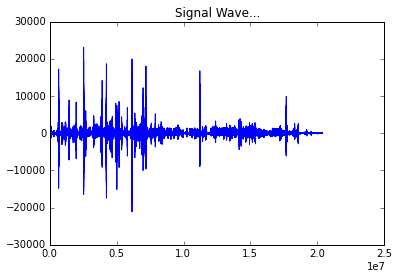

In [3]:
plt.title('Signal Wave...')
plt.plot(signal)

In [4]:
signal_wiener_filtered = wiener(signal, mysize=101)

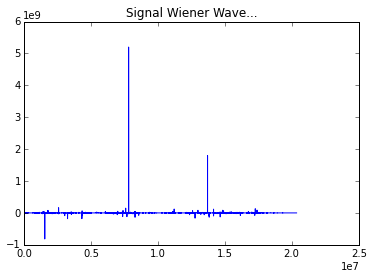

In [5]:
#signal_wiener_filtered[numpy.isnan(signal_wiener_filtered)] = 0
plt.title('Signal Wiener Wave...')
plt.plot(signal_wiener_filtered)

In [6]:
features = mfcc(signal_wiener_filtered, samplerate=rate, numcep=36, winlen=0.03,winstep=0.02)
energy = features[:,0]
# indexing after sorting in ascending order based on energy
# energy.sort()
energy_sort_a_index = numpy.argsort(energy)
energy_sort_d_index = energy_sort_a_index[::-1]

ten_percent_highest_energy_index = energy_sort_d_index[0:int(len(features)*.1)]
twenty_percent_lowest_energy_index = energy_sort_a_index[0:int(len(features)*.2)]

sp = features[ten_percent_highest_energy_index][:]
nsp = features[twenty_percent_lowest_energy_index][:]

In [7]:
sp


array([[  4.47182310e+01,  -3.67203670e+01,  -1.04427720e+01, ...,
          1.38990931e-02,   4.32798563e-02,   4.25979301e-02],
       [  4.25933603e+01,  -3.67204165e+01,  -1.04441878e+01, ...,
          1.38939052e-02,   4.33510901e-02,   4.25367444e-02],
       [  4.25933583e+01,  -3.67203450e+01,  -1.04440710e+01, ...,
          1.38923048e-02,   4.33193680e-02,   4.25093265e-02],
       ..., 
       [  2.51729879e+01,  -3.39102572e+01,  -1.63587246e+00, ...,
         -6.07487160e-02,  -2.10630652e-01,   1.84062368e-01],
       [  2.51723388e+01,  -3.64857964e+01,  -1.06046850e+01, ...,
         -3.54796448e-02,  -6.89169014e-02,  -4.82406210e-01],
       [  2.51715707e+01,  -3.52653110e+01,  -9.37638952e+00, ...,
         -9.85826626e-03,   4.79505646e-01,  -6.54546370e-01]])

In [8]:
nsp

array([[  9.76237719,   3.28563623,  17.76772216, ...,   0.34909876,
          1.47630407,   0.60182208],
       [  9.78004677,   4.61889412,  21.83358019, ...,  -0.18873443,
         -1.33235486,  -1.74862987],
       [  9.80695008,   2.35103545,  17.05580149, ...,  -0.45214305,
         -0.56131454,  -0.09141073],
       ..., 
       [ 16.09531757, -28.64638655,  29.34668578, ...,   0.22689946,
          0.32424635,   0.74068985],
       [ 16.09623632, -11.69171364,   2.76869271, ...,  -0.05240279,
         -0.43010047,   0.76109028],
       [ 16.09624224, -28.81098722,   5.23957678, ...,   0.07819018,
          1.79328586,   0.03059444]])

In [9]:
Gsp = GMM(n_components=16)
Gsp.fit(sp)
Gnsp = GMM(n_components=4)
Gnsp.fit(nsp)

I_old = len(sp);
J_old = len(nsp);
percent_change = 100;
counter = 0;

while(percent_change > 1):
    counter = counter + 1;
    print 'counter: ' + str(counter)

    # compute likelihood that frame is speech
    LLsp = Gsp.score(features)
    # compute likelihood that frame is non-speech
    LLnsp = Gnsp.score(features)

    print len(features)

    # get data for next iteration of training both models
    sp = features[LLsp > LLnsp,:]
    nsp = features[LLnsp > LLsp,:]

    # re-train the models for speech and non-speech
    Gsp = GMM(n_components=32)
    Gsp.fit(sp)
    Gnsp = GMM(n_components=8)
    Gnsp.fit(nsp)

    I_new = len(sp);
    J_new = len(nsp);

    print 'I_old: ' + str(I_old)
    print 'J_old: ' + str(J_old)
    print 'I_new: ' + str(I_new)
    print 'J_new: ' + str(J_new)

    sub = abs(I_new - I_old) * 1.0
    print 'sub: ' + str(sub)
    div = sub/I_old * 1.0
    print 'div : ' + str(div)
    percent_change = div * 100
    print 'percent_change:' + str(percent_change)
    I_old = I_new
    J_old = J_new

likelihood = LLnsp > LLsp
print likelihood
if likelihood[0] == True:
    previousType = 'nsp'
else:
    previousType = 'sp'
fromIndex = 0
toIndex = 0


for i in range(1, len(likelihood)):
    if likelihood[i] == True:
        currentType = 'nsp'
    else:
        currentType = 'sp'
    # print currentType
    # print previousType
    if currentType == previousType or (toIndex - fromIndex < 35):
        toIndex = i
    else:
        print 'Length: ' + str(toIndex - fromIndex + 1) + ' From: ' + str(fromIndex) + ' To: ' + str(toIndex) + ' Type: ' + currentType
        fromIndex = i
        toIndex = i
        previousType = currentType
print 'Length: ' + str(toIndex - fromIndex) + ' From: ' + str(fromIndex) + ' To: ' + str(toIndex) + ' Type: ' + currentType


counter: 1
63632
I_old: 6363
J_old: 12726
I_new: 20019
J_new: 43613
sub: 13656.0
div : 2.14615747289
percent_change:214.615747289
counter: 2
63632
I_old: 20019
J_old: 43613
I_new: 21402
J_new: 42230
sub: 1383.0
div : 0.0690843698486
percent_change:6.90843698486
counter: 3
63632
I_old: 21402
J_old: 42230
I_new: 22518
J_new: 41114
sub: 1116.0
div : 0.0521446593776
percent_change:5.21446593776
counter: 4
63632
I_old: 22518
J_old: 41114
I_new: 23604
J_new: 40028
sub: 1086.0
div : 0.0482280841993
percent_change:4.82280841993
counter: 5
63632
I_old: 23604
J_old: 40028
I_new: 24820
J_new: 38812
sub: 1216.0
div : 0.0515166920861
percent_change:5.15166920861
counter: 6
63632
I_old: 24820
J_old: 38812
I_new: 25920
J_new: 37712
sub: 1100.0
div : 0.044319097502
percent_change:4.4319097502
counter: 7
63632
I_old: 25920
J_old: 37712
I_new: 27012
J_new: 36620
sub: 1092.0
div : 0.0421296296296
percent_change:4.21296296296
counter: 8
63632
I_old: 27012
J_old: 36620
I_new: 28002
J_new: 35630
sub: 990.0
